# Imports

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,685 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,126 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8

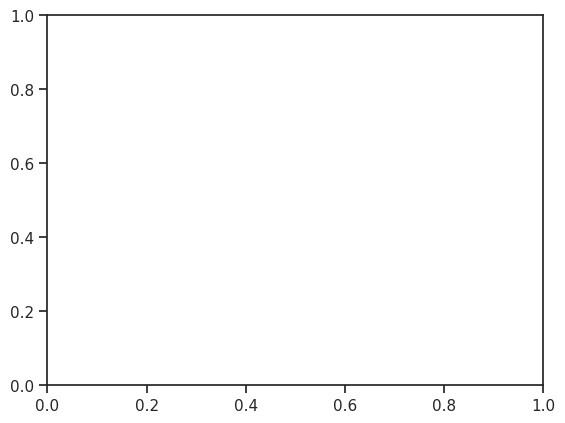

In [ ]:
!apt-get update
!apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install numpyro
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="ticks")

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

%matplotlib inline
from typing import Callable
import matplotlib.pyplot as plt
from jax import numpy as jnp
from jax import scipy
from jax import random, Array, jit, vmap, grad
from jax.tree_util import Partial as partial
from jax.lax import fori_loop, cond, dynamic_slice, dynamic_update_slice
import numpyro
import optax
import jax
#from jax.config import config

#config.update("jax_debug_nans", True)
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
#optax.clip_by_global_norm(1)
import pickle
import sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pickle

Mounted at /content/drive


In [ ]:
key = random.PRNGKey(0)

# Import data, split train and test

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

X, y = fetch_openml(data_id=181, as_frame=True, return_X_y=True)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train = X[:1300, :]
y_train = y[:1300]
X_test = X[1300:, :]
y_test = y[1300:].reset_index()
y.value_counts().sort_index()

,count
class_protein_localization,
CYT,463
ERL,5
EXC,35
ME1,44
ME2,51
ME3,163
MIT,244
NUC,429
POX,20


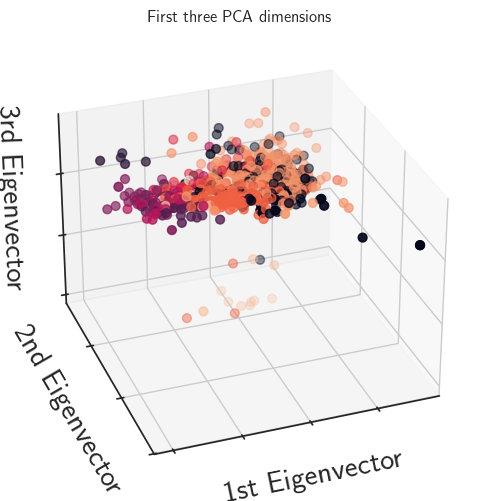

In [ ]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
 # noqa: F401

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c = np.array([cats[c] for c in y]),
    s=40,
)

ax.set(
    title="First three PCA dimensions",
    xlabel="1st Eigenvector",
    ylabel="2nd Eigenvector",
    zlabel="3rd Eigenvector",
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

In [ ]:
X = X_reduced
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train = X[:1300, :]
y_train = y[:1300]
X_test = X[1300:, :]
y_test = y[1300:].reset_index()
y.value_counts().sort_index()

,count
class_protein_localization,
CYT,463
ERL,5
EXC,35
ME1,44
ME2,51
ME3,163
MIT,244
NUC,429
POX,20


In [ ]:
cats = {"CYT" : 0, "ERL": 1, "EXC": 2, "ME1": 3, "ME2": 4, "ME3": 5, "MIT": 6, "NUC": 7, "POX": 8, "VAC": 9}
cats_reversed = {0: "CYT", 1: "ERL", 2:"EXC", 3:"ME1", 4:"ME2", 5:"ME3", 6:"MIT", 7:"NUC", 8:"POX", 9:"VAC"}

# Target measure, kernel and test functions

In [ ]:
def norm_2_safe_for_grad(x) :

      return jnp.power(jnp.linalg.norm(jnp.where(x != 0., x, 0.)), 2)

def K(x, y):#gaussian kernel

      d_i = 3
      sigma2 = 1e-2
      return jnp.power(norm_2_safe_for_grad(x-y) + 10**-2, -(d_i-2)/2)
      #return jnp.exp(-0.5* norm_2_safe_for_grad(x-y) / sigma2)/(sigma2)**(d/2)

In [ ]:
#\beta_0, \beta_1, \beta_2, \beta_3 \sim iid from N(0, 10) truncated at 100 for each class
#prior on parameters
sigma = 10.

class gaussian_trunc(numpyro.distributions.Distribution) :

    def __init__(self):

        self.d = 1
        self.sigma = sigma
        event_shape = (1, )
        super(gaussian_trunc, self).__init__(event_shape = event_shape)

    def outlier(self, value):

        return jnp.linalg.norm(value) >= 5*self.sigma

    def log_prob(self, value) :

        out = self.outlier(value)
        res = cond(out,
                   lambda _ : -jnp.inf,
                   lambda _ : -jnp.linalg.norm(value)**2/(2*self.sigma**2),
                   None)

        return res

class gaussian_trunc_mult(numpyro.distributions.Distribution) :

    def __init__(self):

        event_shape = (9*9, ) #intercept + 8 features, 10 class but the prob for the last one is 1 minus the others
        #event_shape = (4*9, ) #with pca: intercept + 3 features, 10 class but the prob for the last one is 1 minus the others
        super(gaussian_trunc_mult, self).__init__(event_shape = event_shape)

    def log_prob(self, value):

        return jit(vmap(gaussian_trunc().log_prob))(value)

In [ ]:
key, _ = random.split(key, 2)
target = gaussian_trunc_mult()
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(36), covariance_matrix= jnp.eye(36))
mvn_samples = mvn.sample(key, (1, ))
target.log_prob(mvn_samples)

Array([-0.22025163], dtype=float64)

In [ ]:
#incorporate likelihood from the data

def log_sigmoid(value_k, x):

    return jnp.dot(value_k, jnp.concatenate([jnp.array([1.]), x]))

def log_sigmoid_normalized(x, y, value_reshaped, K_max):
    cat = y
    log_sigmoids = jit(vmap(partial(log_sigmoid, x = x)))
    sigmoids = log_sigmoids(value_reshaped[:(K_max -1), :])
    sm = scipy.special.logsumexp(jnp.concatenate([sigmoids, jnp.array([1.])]))

    return jnp.where(cat == K_max, -sm, log_sigmoids(value_reshaped[cat, :])[0]- sm)

class logit_prior(numpyro.distributions.Distribution):

    def __init__(self):

        self.K_max = 9
        event_shape = (4*9, ) #for pca : intercept + 3 features, 10 class but the prob for the last one is 1 minus the others
        #event_shape = (4*9, )
        super(logit_prior, self).__init__(event_shape = event_shape)

    def log_prob(self, value):

        n_features = X_train[0, :].shape[0]
        value_reshaped = value.reshape((n_features+1, self.K_max)).T
        cat_train = jnp.array([cats[y] for y in y_train], dtype = int)
        n_train = y_train.shape[0]
        s = jit(vmap(partial(log_sigmoid_normalized, value_reshaped = value_reshaped, K_max = self.K_max)))(X_train, cat_train).sum()

        return gaussian_trunc_mult().log_prob(value) + s


In [ ]:
key, _ = random.split(key, 2)
target = logit_prior()
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(36), covariance_matrix= jnp.eye(36))
mvn_samples = mvn.sample(key, (1, ))
target.log_prob(mvn_samples)

Array([-18569.54131179], dtype=float64)

In [ ]:
#likelihood for bayesian logistic regression using test data
n_features = X_train[0, :].shape[0]
K_max = target.K_max

def log_likelihood(value_reshaped, x, y):

    log_lik_x = log_sigmoid_normalized(x = x, y = y, value_reshaped= value_reshaped, K_max = K_max)

    return log_lik_x

#compute posterior probability to predict each class with given samples from the prior and data
def log_posterior(samples, x, cat = "CYT"):
    n, d_sample = samples.shape
    y = cats[cat]
    samples_reshaped = samples.reshape(n, K_max, n_features +1)
    f_log_post = lambda value : log_likelihood(value_reshaped = value, x=x, y = y)
    log_post = scipy.special.logsumexp(jit(vmap(f_log_post))(samples_reshaped))  #pb ici ? il veut fiare les chsoes en vectorisé ? le format est pas bon
    return log_post - jnp.log(n)

def classify(samples, x):

    log_posts = np.array([log_posterior(samples, x = x, cat = cat) for cat in cats.keys()])
    khat =  cats_reversed[np.argmax(log_posts)]
    return khat


In [ ]:
key, _ = random.split(key, 2)
samples = mvn.sample(key, (10, ))
classify(samples, x = X_test[50, :])

'ERL'

In [ ]:
y_test.iloc[50]

,50
index,1350
class_protein_localization,CYT


# Gibbs target and MALA

In [ ]:
class gibbs(numpyro.distributions.Distribution) :

    def __init__(self, d, N, K, V, beta_N) :

        self.N = N
        self.K = K
        self.V = V
        self.d = d
        self.beta_N = beta_N
        event_shape = (N, d)
        super(gibbs, self).__init__(event_shape = event_shape)


    def log_prob(self, value) :

        #value = (x_1, \dots, x_N) d*N

        value_shape = value.shape #should be (1, N*d)
        #X = jnp.array(value.reshape(self.d, self.N))
        X = jnp.array(value.reshape(self.N, self.d).T)
        index = jnp.array([k for k in range(self.N)])

        k_inter = lambda j ,k : self.K(X[:, j], X[:, k])

        pair_j = lambda j : jit(vmap(partial(k_inter, j)))(index).sum()
        diag = jit(vmap(k_inter))(index, index).sum()
        #diag = 0
        pair_jit = jit(vmap(pair_j))(index).sum()
        #pair_jit = jnp.array([[k_inter(j, k) for k in index] for j in index]).sum()
        #pair_inter = jnp.log(self.beta_N) +jnp.log(pair_jit - diag ) -jnp.log(2) - 2*jnp.log(self.N)
        pair_inter = self.beta_N * (pair_jit - diag) / (2 * self.N**2)

        v_inter = lambda j : self.V(X[:, j])
        ext_jit = jit(vmap(v_inter))(index).sum()
        #ext_jit = jnp.array([v_inter(j) for j in index]).sum()
        #exter_V =  jnp.log(self.beta_N) +jnp.log(ext_jit) - jnp.log(self.N)
        exter_V = self.beta_N * ext_jit / self.N
        return - pair_inter - exter_V
        #return  -jnp.exp(exter_V)*(jnp.exp(pair_inter - exter_V) +1)

In [ ]:
def logsumexp(a, axis=None):
  c = jnp.max(a, axis=axis, keepdims=True)
  safe = jnp.isfinite(c)
  c = jnp.where(safe, c, 0)
  e = jnp.exp(a - c)
  z = jnp.sum(e, axis=axis)
  safe = z != 0
  log_z = jnp.where(safe, jnp.log(jnp.where(safe, z, 1)), -jnp.inf)
  r = jnp.squeeze(c, axis=axis) + log_z
  return r


def K_log(x, y):#gaussian kernel

      #return jnp.power(norm_2_safe_for_grad(x-y) + 10**-2, -(3-2)/2)
      return -0.5* norm_2_safe_for_grad(x-y)

def V_ext(x):

    R_2 = 4*9*(5* sigma)**2
    #R_2 = 25*81
    #outlier = (logit_prior().log_prob(x.reshape((1, 81))) < -1e5)
    outlier = norm_2_safe_for_grad(x) >= R_2
    res = jnp.where(outlier, norm_2_safe_for_grad(x) - R_2, 0.)
    #res = jnp.where(outlier, 1e5, 0.)
    return res

def V_log(x) :
    d, N_mh = sample_mh_pot.shape
    #attention dans le papier simods j'ai pris le même échantillon mcmc pour tous les x, c'est ok car on a les garanties en W_1 mais est ce qu'on a pas intérêt à indep ?
    log_k_inter = lambda j : K_log(x, sample_mh_pot[:, j])
    v_inter = logsumexp(jit(vmap(log_k_inter))(jnp.array([k for k in range(N_mh)]))) -jnp.log(N_mh)
    v = jnp.log(V_ext(x) - jnp.exp(v_inter))
    #jax.debug.print("{v}", v = v_ext_x)

    return v

class gibbs_logs(numpyro.distributions.Distribution) :

    def __init__(self, d, N, K_log, V_log, beta_N) :

        self.N = N
        self.K_log = K_log
        self.V_log = V_log
        self.d = d
        self.beta_N = beta_N
        event_shape = (N, d)
        super(gibbs_logs, self).__init__(event_shape = event_shape)


    def log_prob(self, value) :

        #value = (x_1, \dots, x_N)

        value_shape = value.shape #should be (1, N*d)
        X = jnp.array(value.reshape(self.d, self.N))
        index = jnp.array([k for k in range(self.N)])

        k_inter = lambda j ,k : self.K_log(X[:, j], X[:, k])

        log_pair_j = lambda j : logsumexp(jit(vmap(partial(k_inter, j)))(index))
        log_diag = logsumexp(jit(vmap(k_inter))(index, index))
        #diag = 0
        log_pair_jit = logsumexp(jit(vmap(log_pair_j))(index))
        #pair_jit = jnp.array([[k_inter(j, k) for k in index] for j in index]).sum()
        #pair_inter = jnp.log(self.beta_N) +jnp.log(pair_jit - diag ) -jnp.log(2) - 2*jnp.log(self.N)
        log_pair_inter = jnp.log(self.beta_N) + (logsumexp(jnp.array([log_pair_jit, log_diag]))) - jnp.log(2) - 2 *jnp.log(self.N)

        v_inter = lambda j : self.V_log(X[:, j])
        log_ext_jit = logsumexp(jit(vmap(v_inter))(index))
        #ext_jit = jnp.array([v_inter(j) for j in index]).sum()
        #exter_V =  jnp.log(self.beta_N) +jnp.log(ext_jit) - jnp.log(self.N)
        log_exter_V = jnp.log(self.beta_N) + log_ext_jit - jnp.log(self.N)

        return - jnp.exp(logsumexp(jnp.array([log_pair_inter, log_exter_V])))
        #return  -jnp.exp(exter_V)*(jnp.exp(pair_inter - exter_V) +1)

In [ ]:
def mala(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key, 0.)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))

    def mh_step(i, val):

        sample, key, acceptance = val
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel

        noise = random.normal(subkey_sample, (sample.shape[-1],))
        grad = grad_logpdf(sample)
        next = sample + step_size * grad / (1+jnp.linalg.norm(grad)) \
               + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        grad_next = grad_logpdf(next)
        bwd_ker_logprob = - ((sample - next - step_size * grad_next / (1+jnp.linalg.norm(grad_next)))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob



        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        acceptance = (i*acceptance + accept)/(i+1)

        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        return (x, key, acceptance)

    sample, k, acceptance = fori_loop(0,
                          n_iter,
                          body_fun=mh_step,
                          init_val=val)
    return sample, acceptance

In [ ]:
def mala_one_p(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    key, subkey_p, _ = random.split(key, 3)
    #all_pos_p = random.randint(subkey_p, (n_iter+1, ), minval = 0, maxval = N)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))
    #all_pos = np.random.randint(0, N, size = n_iter)
    val = (start_sample, key, 0.)
    def mh_step(i, val):

        sample, key, acceptance = val
        key, subkey_u, subkey_sample, subkey_p = random.split(key, 4)
        #Sample the langevin kernel
        pos = random.randint(subkey_p, shape = (1, ), minval = np.array([0]), maxval = np.array([N]))

        noise = random.normal(subkey_sample, (N*d,))
        #pos = np.random.randint(0, N, size = 1)[0]
        #grad_p = dynamic_slice(grad_logpdf(sample),  start_indices = np.array([pos]), slice_sizes = np.array([d]))
        grad_sample = grad_logpdf(sample)
        next_p = step_size * grad_sample / (1+jnp.linalg.norm(grad_sample)) \
               + jnp.sqrt(2 * step_size) * noise
        grads = jnp.zeros_like(sample)
        #grads = grads.at[pos*d:(pos+1)*d].set(jnp.ones(d))
        grads = dynamic_update_slice(grads, jnp.ones((d,)), (jnp.squeeze(pos) * d,))
        next = sample + grads*next_p
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        grad_next = grad_logpdf(next)
        bwd_ker_logprob = - ((sample - next - step_size * grads*grad_next/(1+jnp.linalg.norm(grad_next)))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob

        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        acceptance = (i*acceptance + accept)/(i+1)

        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)

        return (x, key, acceptance)

    sample, k, acceptance = fori_loop(0,
                          n_iter,
                          body_fun=mh_step,
                          init_val=val)
    return sample, acceptance

# Target measure and MCMC to approximate the potential

In [ ]:
def mh(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key, 0.)
    start_sample = jnp.atleast_2d(start_sample)

    def mh_step(i, val):

        positions, key, acceptance = val
        sample = jnp.atleast_2d(positions[i-1, :])
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel
        noise = random.normal(subkey_sample, (sample.shape[-1],))
        next = sample + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        bwd_ker_logprob = - ((sample - next)**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob

        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        #x = cond(accept,
        #         lambda _: next,
        #         lambda _: sample,
        #         None)
        x = jnp.where(log_ratio > log_u, next, sample)

        acceptance = (i*acceptance + accept)/(i+1)
        positions = positions.at[i, :].set(jnp.atleast_2d(x)[0, :])
        return (positions, key, acceptance)

    all_positions = jnp.zeros((n_iter, start_sample.shape[1]))
    all_positions = all_positions.at[0, :].set(start_sample[0, :])

    positions, key, acceptance = fori_loop(1,
                          n_iter,
                          body_fun=mh_step,
                          init_val=(all_positions, key, jnp.array([0.])))
    return positions, acceptance

In [ ]:
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 100_000,
                                step_size = 4e-5))
initial_positions = mvn.sample(key, (1, ))
sample_mh_pot_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)

In [ ]:
key, _ = random.split(key, 2)
indexes = random.randint(key, shape = (1_000, ), minval = jnp.array([50_000]), maxval = jnp.array([100_000]))
sample_mh_pot = sample_mh_pot_jit[0, indexes, :].T

In [ ]:
#sample_mh_pot = sample_mh_pot_jit[0, 50_000:100_000, :].T

In [ ]:
acceptance

Array([[0.56059]], dtype=float64)

In [ ]:
def V_ext(x):

    #R_2 = 4*9*(5* sigma)**2
    #R_2 = 25*81
    outlier = (logit_prior().log_prob(x.reshape((1, 36))) == -jnp.inf)
    #outlier = norm_2_safe_for_grad(x) >= R_2
    #res = jnp.where(outlier, norm_2_safe_for_grad(x) - R_2, 0.)
    res = jnp.where(outlier, jnp.inf, 0.)
    return res

def V(x) :
    d, N_mh = sample_mh_pot.shape
    #attention dans le papier simods j'ai pris le même échantillon mcmc pour tous les x, c'est ok car on a les garanties en W_1 mais est ce qu'on a pas intérêt à indep ?
    k_inter = lambda j : K(x, sample_mh_pot[:, j])
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / N_mh
    v = V_ext(x) - v_inter
    #jax.debug.print("{v}", v = V_ext(x))

    return v

# Compute probability estimates with long MCMC chains and classify

In [ ]:
d = 36
N = 100
key, _  = random.split(key, 2)
beta_N = 2*N**2
step_size = 1e-3 * (beta_N)**(-1)
n_iter = 10_000
target_mala = gibbs(d = d, N = N, K = K, V = V, beta_N = beta_N)
mala_jitted = jit(vmap(partial(mala,
                               log_prob_target = target_mala.log_prob,
                               n_iter = n_iter,
                               step_size =  step_size)))

In [ ]:
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_init = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 100_000,
                                step_size = 4e-5))
initial_positions = mvn.sample(key, (1, ))
start_sample_mh, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)

In [ ]:
key, _ = random.split(key, 2)
indexes = random.randint(key, shape = (N, ), minval = jnp.array([50_000]), maxval = jnp.array([100_000]))
start_sample = start_sample_mh[0, indexes, :].reshape(1, d*N)
sample_mala, acceptance = mala_jitted(random.split(key, 1), start_sample)
print(acceptance)

[0.5488]


# Compute estimates and simultaneous confidence intervals with Gibbs and classify

## One chain and classify

In [ ]:
key, _ = random.split(key, 2)
d = 36
N = 100
beta_N = 2*N**2
target_mala = gibbs_logs(d = d, N = N, K = K, V = V, beta_N = beta_N)
mvn_d = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn_d.sample(key, (1, ))

In [ ]:
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target_mala.log_prob,
                               n_iter = 10_000,
                               step_size =  0.01 * beta_N**(-1))))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N).T
#sample_mala_reshaped = sample_mala.reshape((n_chains, d, N)).T
#classify(sample_mala_reshaped, x = X_test[0, :])

In [ ]:
sample_mala_reshaped

Array([[-0.21022036,  0.37365164, -0.86603561, ...,  1.74583989,
         0.68863076,  0.43664929],
       [-0.40866136, -3.04816463, -1.55106687, ..., -0.22393197,
        -1.74872247,  0.79185282],
       [-0.70987667,  0.12203354,  2.38018893, ...,  0.03765181,
         0.97003735,  0.67406929],
       ...,
       [ 0.63098112, -0.49025407, -0.82912314, ...,  0.94809742,
        -1.27525514, -0.06205483],
       [ 0.28271069, -0.53505393,  0.62540374, ...,  0.67770592,
         1.21857353,  1.06645349],
       [ 1.18697898,  0.3300827 ,  0.81312536, ...,  1.11951992,
         1.207932  , -1.42598009]], dtype=float64)

In [ ]:
y_test.iloc[0]

,0
index,1300
class_protein_localization,CYT


# Same stuff for MCMC

In [ ]:
n_chains = 50
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 100_000,
                                step_size = 5e-4))
initial_positions = mvn.sample(key, (n_chains, ))
chains_mh_step_short, acceptance = jit(sample_mh_jit)(random.split(key, n_chains), initial_positions)
acceptance

Array([[0.0377 ],
       [0.03589],
       [0.0371 ],
       [0.03779],
       [0.036  ],
       [0.0359 ],
       [0.038  ],
       [0.03701],
       [0.03594],
       [0.03583],
       [0.03565],
       [0.0361 ],
       [0.03659],
       [0.03833],
       [0.03583],
       [0.03743],
       [0.03619],
       [0.03601],
       [0.03848],
       [0.03635],
       [0.03736],
       [0.03721],
       [0.03627],
       [0.03743],
       [0.03679],
       [0.03699],
       [0.03609],
       [0.03601],
       [0.03746],
       [0.03624],
       [0.0362 ],
       [0.03553],
       [0.03727],
       [0.03606],
       [0.03624],
       [0.03733],
       [0.0374 ],
       [0.03747],
       [0.03827],
       [0.03554],
       [0.03769],
       [0.03754],
       [0.03734],
       [0.0353 ],
       [0.03577],
       [0.03795],
       [0.03607],
       [0.03557],
       [0.03777],
       [0.03662]], dtype=float64)

In [ ]:
chains_mh.shape

(50, 100000, 81)

In [ ]:
dic_mcmc = {"step_size" : 4e-5,
            "acceptance" : acceptance,
            "chains_mh": chains_mh}
pickle.dump(dic_mcmc, open("drive/MyDrive/results_gretsi/mcmc_chains.p", "wb"))

In [ ]:
#long chain for bayes action:
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 1_000_000,
                                step_size = 4e-5))
initial_positions = mvn.sample(key, (1, ))
chain_bayes, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
print(acceptance)
dic_mcmc_bayes = {"step_size" : 4e-5,
                  "acceptance": acceptance,
                  "chain_bayes" : chain_bayes}
pickle.dump(dic_mcmc_bayes, open("drive/MyDrive/results_gretsi/mcmc_bayes_m.p", "wb"))

[[0.276756]]


# Classify and compare, compute Clopper-Pearson confidence intervals

In [ ]:
dic_chain_gibbs_100 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_100.p", "rb"))
dic_chain_gibbs_200 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_200.p", "rb"))
dic_chain_gibbs_300 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_300.p", "rb"))
dic_chain_gibbs_400 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_400.p", "rb"))
dic_chain_gibbs_500 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_500.p", "rb"))
dic_chain_mcmc = pickle.load(open("drive/MyDrive/results_gretsi/mcmc_chains.p", "rb"))
dic_chain_bayes = pickle.load(open("drive/MyDrive/results_gretsi/mcmc_bayes.p", "rb"))
mcmc_chains = dic_chain_mcmc["chains_mh"]
mcmc_bayes = dic_chain_bayes["chain_bayes"]
gibbs_chain_100 = dic_chain_gibbs_100["chains"]
gibbs_chain_200 = dic_chain_gibbs_200["chains"]
gibbs_chain_300 = dic_chain_gibbs_300["chains"]
gibbs_chain_400 = dic_chain_gibbs_400["chains"]
dic_chain_gibbs_500 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_500.p", "rb"))
gibbs_chain_500 = dic_chain_gibbs_500["chains"]

In [ ]:
#predict from the posterior with long mcmc chain
pred_bayes = [classify(mcmc_bayes[0, :, :], X_test[i, :]) for i in range(30)]
dic_chain_bayes["pred_bayes"] = pred_bayes
pickle.dump(dic_chain_bayes, open("drive/MyDrive/results_gretsi/mcmc_bayes.p", "wb"))

In [ ]:
dic_chain_bayes = pickle.load(open("drive/MyDrive/results_gretsi/mcmc_bayes.p", "rb"))
pred_bayes = dic_chain_bayes["pred_bayes"]
print(pred_bayes[16])
y_test.iloc[16]

CYT


,16
index,1316
class_protein_localization,CYT


In [ ]:
def proportions(samples, i, n_chains = 50):
    nchains, N, di = samples.shape
    prop = 0.
    ground = pred_bayes[i]
    #bayes action with long mcmc chain
    for j in range(n_chains):
        pred = classify(samples[j, :, :], X_test[i, :])
        if pred == ground:
            prop+=1.
    prob = prop / n_chains
    return prob

def l_probs_gibbs(i):
    l_probs = np.array([proportions(gibbs_chain_100, i),
                        proportions(gibbs_chain_200, i),
                        proportions(gibbs_chain_300, i),
                        proportions(gibbs_chain_400, i),
                        proportions(gibbs_chain_500, i)])
    return l_probs

def prob_mcmc(i, N):
    return proportions(mcmc_chains[:, :N, :], i)



In [ ]:
#all_probs_gibbs = np.zeros(shape = (184, 5))
#l_probs_mcmc = np.zeros(shape = (184, 1_000))
#dic_all_probs = {"l_probs_gibbs": all_probs_gibbs,
 #                "l_probs_mcmc": l_probs_mcmc}

#pickle.dump(dic_all_probs, open("drive/MyDrive/results_gretsi/all_probs.p", "wb"))
dic_all_probs = pickle.load(open("C:/Users/rouau/Documents/Etudes/Thèse Lille/code/mc-gibbs/results_gretsi/all_probs.p", "rb"))
all_probs_gibbs = dic_all_probs["l_probs_gibbs"]
l_probs_mcmc = dic_all_probs["l_probs_mcmc"]

In [ ]:
for i in range(30):
    print(i)
    all_probs_gibbs[i, :] = l_probs_gibbs(i)
    dic_all_probs["l_probs_gibbs"] = all_probs_gibbs
    pickle.dump(dic_all_probs, open("drive/MyDrive/results_gretsi/all_probs.p", "wb"))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [ ]:
l_mcmc = np.zeros(shape = (30, 10))
for i in range(10):
    print(i)
    for l in range(10):
        l_mcmc[i, l] = prob_mcmc(i, 100*(l+1))
    dic_all_probs["l_probs_mcmc"] = l_mcmc
    pickle.dump(dic_all_probs, open("drive/MyDrive/results_gretsi/all_probs.p", "wb"))

0
1
2
3
4
5
6
7
8
9


NUC


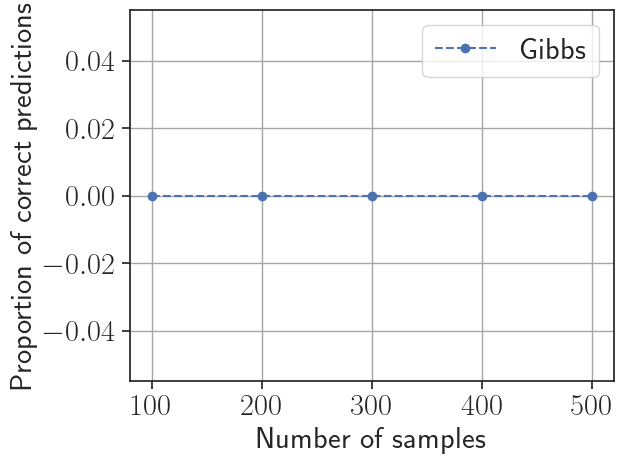

In [ ]:
i = 23
l_labels = [100, 200, 300, 400, 500]
l_labels_mcmc = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
print(pred_bayes[i])
fig, ax = plt.subplots()
ax.plot(np.array(l_labels), all_probs_gibbs[i, :], label = "Gibbs", marker = "o", ls = "--")
#ax.plot(np.array(l_labels_mcmc), l_mcmc[i, :], label = "MCMC", marker = "o", ls = "--")
plt.xlabel("Number of samples")
plt.ylabel("Proportion of correct predictions")
plt.grid(True, which="both", ls="-", color='0.65')
ax.legend()
plt.tight_layout()
plt.show()

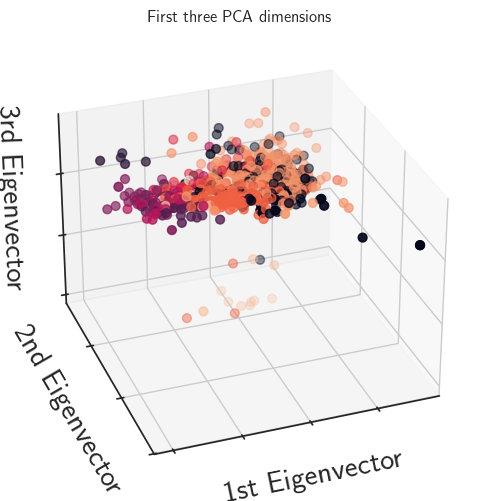

In [ ]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
 # noqa: F401

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c = np.array([cats[c] for c in y]),
    s=40,
)

ax.set(
    title="First three PCA dimensions",
    xlabel="1st Eigenvector",
    ylabel="2nd Eigenvector",
    zlabel="3rd Eigenvector",
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

# Compute all posterior probabilities and check how many runs of MCMC / Gibbs fall in the confidence interval

In [ ]:
dic_chain_gibbs_100 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_100.p", "rb"))
gibbs_chain_100 = dic_chain_gibbs_100["chains"]

(np.float64(-1.9553451374105317),
 np.float64(-1.5003027721421567),
 np.float64(-5.271593869850549),
 np.float64(-3.8474033666870144))

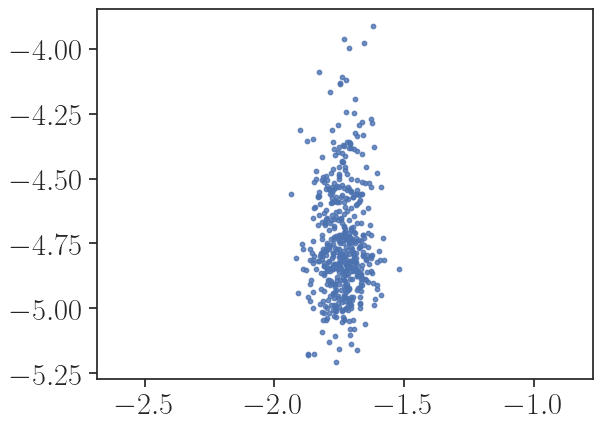

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala.reshape((N, d))[:, :2].T, alpha = 0.8, s = 10)
#axes = plt.gca()
axes.axis('equal')

(np.float64(-1.944979781652553),
 np.float64(-1.505124299105599),
 np.float64(-5.252227584345037),
 np.float64(-3.8696383653907724))

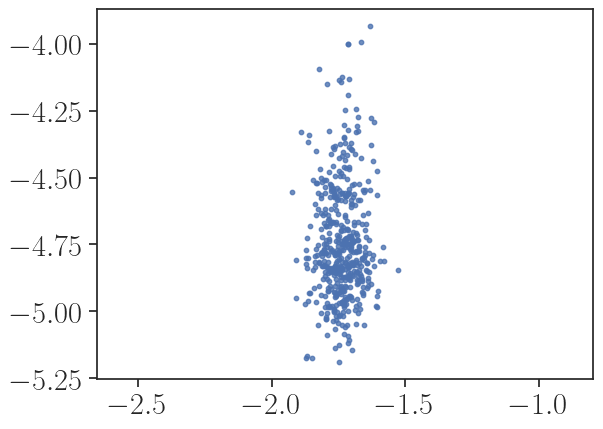

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*start_sample.reshape((N, d))[:, :2].T, alpha = 0.8, s = 10)
#axes = plt.gca()
axes.axis('equal')

In [ ]:
#rebuild gibbs with 100 particles and 100 chains
dic_chain_gibbs_100 = pickle.load(open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_100.p", "rb"))
all_chains = dic_chain_gibbs_100["chains"]
all_acceptance = dic_chain_gibbs_100["acceptance"]
n_chains = 100
N = 100
d = 36
beta_N = 2*N**2
n_iter = 10_000
step_size = 1e-3 * (beta_N)**(-1)
target_mala = gibbs(d = d, N = N, K = K, V = V, beta_N = beta_N)
mvn_d = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= jnp.eye(d))
mala_jitted = jit(vmap(partial(mala,
                               log_prob_target = target_mala.log_prob,
                               n_iter = n_iter,
                               step_size =  step_size)))

In [ ]:
dic_chain_gibbs_100["n_iter"] = n_iter
dic_chain_gibbs_100["step_size"] = step_size
#start sample
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_init = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 100_000,
                                step_size = 4e-5))
initial_positions = mvn.sample(key, (1, ))
start_sample_mh, acceptance = jit(sample_mh_init)(random.split(key, 1), initial_positions)
key, _ = random.split(key, 2)
indexes = random.randint(key, shape = (N, ), minval = jnp.array([50_000]), maxval = jnp.array([100_000]))
start_sample = start_sample_mh[0, indexes, :].reshape(1, d*N)
#mala chains
for i in range(n_chains):
    key, _ = random.split(key, 2)
    sample_mala, acceptance = mala_jitted(random.split(key, 1), start_sample)
    sample_mala_reshaped = sample_mala.reshape(N, d)
    print(acceptance)
    all_acceptance = all_acceptance.at[i].set(acceptance[0])
    all_chains = all_chains.at[i, :, :].set(sample_mala.reshape((N, d)))
    dic_chain_gibbs_100["acceptance"] = all_acceptance
    dic_chain_gibbs_100["chains"] = all_chains
    pickle.dump(dic_chain_gibbs_100, open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_100.p", "wb"))

[0.5739]
[0.5489]
[0.5489]
[0.5824]
[0.5824]
[0.5824]
[0.5825]
[0.5213]
[0.5355]
[0.5356]
[0.5357]
[0.5357]
[0.5198]
[0.5199]
[0.52]
[0.5459]
[0.546]
[0.5201]
[0.5202]
[0.5203]
[0.5203]
[0.5116]
[0.5394]
[0.5394]
[0.5395]
[0.5396]
[0.5559]
[0.5559]
[0.5559]
[0.5553]
[0.5554]
[0.5422]
[0.5422]
[0.5422]
[0.5422]
[0.5423]
[0.5423]
[0.5519]
[0.5519]
[0.5261]
[0.5196]
[0.5229]
[0.5265]
[0.5266]
[0.5579]
[0.558]
[0.5581]
[0.5582]
[0.5582]
[0.5582]
[0.5361]
[0.5362]
[0.5363]
[0.5364]
[0.5365]
[0.5365]
[0.5472]
[0.5472]
[0.5472]
[0.535]
[0.535]
[0.535]
[0.5374]
[0.5374]
[0.5444]
[0.5444]
[0.5445]
[0.5548]
[0.5339]
[0.5339]
[0.5339]
[0.5432]
[0.5433]
[0.5433]
[0.5434]
[0.5481]
[0.5482]
[0.5287]
[0.5288]
[0.5289]
[0.5372]
[0.5622]
[0.5391]
[0.512]
[0.512]
[0.5026]
[0.5027]
[0.5027]
[0.5028]
[0.5029]
[0.5195]
[0.5195]
[0.5195]
[0.5196]
[0.5197]
[0.4777]
[0.5502]
[0.5531]
[0.5413]
[0.5414]


In [ ]:
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_bayes = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 1_000_000,
                                step_size = 4e-5))
initial_positions = mvn.sample(key, (1, ))
sample_bayes, acceptance = jit(sample_mh_bayes)(random.split(key, 1), initial_positions)
sample_bayes_wo_burn = sample_bayes[:, 100_000:, :]

In [ ]:
acceptance

Array([[0.520663]], dtype=float64)

In [ ]:
y_test["class_protein_localization"].value_counts().sort_index()

,count
class_protein_localization,
CYT,45
ERL,0
EXC,2
ME1,16
ME2,7
ME3,43
MIT,18
NUC,36
POX,4


In [ ]:
l_bayes = np.array([classify(sample_bayes_wo_burn[0, :, :], X_test[i, :]) for i in range(184)])
print(l_bayes)

['EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC'
 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'EXC' 'E

In [ ]:
key, _ = random.split(key, 2)
target = gaussian_trunc_mult()
sample_mh_prior = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 100_000,
                                step_size = 4e-5))
initial_positions = mvn.sample(key, (1, ))
sample_prior, acceptance = jit(sample_mh_bayes)(random.split(key, 1), initial_positions)
sample_prior_wo_burn  =sample_prior[:, 50_000:, :]
indexes = random.randint(key, shape = (100, ), minval = jnp.array([50_000]), maxval = jnp.array([100_000]))
sample_opt_init = sample_prior_wo_burn[:, indexes, :]

In [ ]:
from scipy.optimize import minimize
def f(x):
    return -target.log_prob(x.reshape((1, 36)))
l_res_opt = np.array([minimize(f, x0 = sample_opt_init[0, k, :]) for k in range(100)])

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_bayes_wo_burn[:, :2].T, alpha = 0.8, s = 10)
#axes = plt.gca()
axes.axis('equal')

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*l_res_opt[:, :2].T, alpha = 0.8, s = 10)
#axes = plt.gca()
axes.axis('equal')

In [ ]:
#mh samples
n_chains = 100
key, _ = random.split(key, 2)
target = logit_prior()
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target.log_prob,
                                n_iter = 100_000,
                                step_size = 4e-5))
initial_positions = mvn.sample(key, (n_chains, ))
sample_mh_full, acceptance = jit(sample_mh_jit)(random.split(key, n_chains), initial_positions)
sample_mh_100 = sample_mh_full[:, 50_000:50_100, :]
sample_mh_1000 = sample_mh_full[:, 50_000:51_000, :]
sample_mh_5000 = sample_mh_full[:, 50_000:55_000, :]
sample_mh_10_000 = sample_mh_full[:, 50_000:60_000, :]
sample_mh_50_000 = sample_mh_full[:, 50_000:100_000, :]
sample_mh_wo_burn = sample_mh_full[:, 50_000:100_000, :]
#for i in range(n_chains):
 #   indexes_100 = random.randint(key, shape = (100, ), minval = jnp.array([50_000]), maxval = jnp.array([100_000]))
  #  sample_mh_100 = sample_mh_100.at[i, :, :].set(sample_mh_wo_burn[i, indexes_100, :]   )

   # indexes_1000 = random.randint(key, shape = (1000, ), minval = jnp.array([50_000]), maxval = jnp.array([100_000]))
    #sample_mh_1000 = sample_mh_1000.at[i, :, :].set(sample_mh_wo_burn[i, indexes_1000, :]   )

    #indexes_5000 = random.randint(key, shape = (5000, ), minval = jnp.array([50_000]), maxval = jnp.array([100_000]))
    #sample_mh_5000 = sample_mh_5000.at[i, :, :].set(sample_mh_wo_burn[i, indexes_5000, :]   )

    #indexes_10_000 = random.randint(key, shape = (10_000, ), minval = jnp.array([50_000]), maxval = jnp.array([100_000]))
    #sample_mh_10_000 = sample_mh_10_000.at[i, :, :].set(sample_mh_wo_burn[i, indexes_10_000, :]   )


In [ ]:
i = 0
n_chains = 100
#log posterior probabilities for long MH
log_post_bayes = np.array([log_posterior(sample_bayes_wo_burn[0, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
z = scipy.special.logsumexp(log_post_bayes)
log_post_bayes = log_post_bayes #- z#scipy.special.logsumexp(log_post_bayes)

In [ ]:
np.exp(log_post_bayes)

array([1.51408460e-21, 1.70330632e-21, 1.01223065e+00, 1.54437224e-21,
       1.54257882e-21, 1.55032622e-21, 1.54734567e-21, 1.52109601e-21,
       1.53295409e-21, 1.53079456e-21])

In [ ]:
#idem for Gibbs
gibbs_chain_100 = dic_chain_gibbs_100["chains"]
log_post_gibbs = np.zeros(shape = (n_chains, 10))
for j in range(n_chains):
    log_post_gibbs_j = np.array([log_posterior(gibbs_chain_100[j, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
    log_post_gibbs[j, :] = log_post_gibbs_j #-  scipy.special.logsumexp(log_post_gibbs_j)

In [ ]:
#idem for short MH
log_post_mcmc_100 = np.zeros(shape = (n_chains, 10))
for j in range(n_chains):
    log_post_mcmc_j_100 = np.array([log_posterior(sample_mh_100[j, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
    log_post_mcmc_100[j, :] = log_post_mcmc_j_100 #- scipy.special.logsumexp(log_post_mcmc_j_100)


#mh 1000
log_post_mcmc_1000 = np.zeros(shape = (n_chains, 10))
for j in range(n_chains):
    log_post_mcmc_j_1000 = np.array([log_posterior(sample_mh_1000[j, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
    log_post_mcmc_1000[j, :] = log_post_mcmc_j_1000 #- scipy.special.logsumexp(log_post_mcmc_j_1000)

    #mh 5000
log_post_mcmc_5000 = np.zeros(shape = (n_chains, 10))
for j in range(n_chains):
    log_post_mcmc_j_5000 = np.array([log_posterior(sample_mh_5000[j, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
    log_post_mcmc_5000[j, :] = log_post_mcmc_j_5000 #- scipy.special.logsumexp(log_post_mcmc_j_5000)

    #mh 10_000
log_post_mcmc_10_000 = np.zeros(shape = (n_chains, 10))
for j in range(n_chains):
    log_post_mcmc_j_10_000 = np.array([log_posterior(sample_mh_10_000[j, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
    log_post_mcmc_10_000[j, :] = log_post_mcmc_j_10_000 #- scipy.special.logsumexp(log_post_mcmc_j_10_000)

#mh 50_000
log_post_mcmc_50_000 = np.zeros(shape = (n_chains, 10))
for j in range(n_chains):
    log_post_mcmc_j_50_000 = np.array([log_posterior(sample_mh_50_000[j, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
    log_post_mcmc_50_000[j, :] = log_post_mcmc_j_50_000 #- scipy.special.logsumexp(log_post_mcmc_j_10_000)

In [ ]:
def props_in_ci(log_posts, delta):
    n_chains, n_cats = log_posts.shape
    prop_ci = 0.
    #l_prob_ci_up = np.zeros(shape = (n_cats))
    l_prob_ci_up = np.array([np.inf for i in range(n_cats)])
    l_prob_ci_down = np.array([-np.inf for i in range(n_cats)])
    for i in range(n_cats):
        #if log_post_bayes[i] < np.log(1 - delta):
        l_prob_ci_up[i] = scipy.special.logsumexp(a = jnp.array([log_post_bayes[i], jnp.log(delta)]))
        #if log_post_bayes[i] > np.log(delta):
        l_prob_ci_down[i] = scipy.special.logsumexp(a = jnp.array([log_post_bayes[i], jnp.log(delta)]), b = jnp.array([1., -1.]))

    for j in range(n_chains):
        flag = True
        for i in range(n_cats):
            l_prob = log_posts[j, i]
            if l_prob > l_prob_ci_up[i] or l_prob < l_prob_ci_down[i]:
                flag = False
        if flag:
            prop_ci+=1.
    return prop_ci / n_chains



In [ ]:
props_in_ci(log_post_mcmc_10_000, delta = 0.)

0.0

In [ ]:
log_post_bayes

array([-4.79394759e+01, -4.78217157e+01,  1.21564589e-02, -4.79196694e+01,
       -4.79208314e+01, -4.79158216e+01, -4.79177460e+01, -4.79348558e+01,
       -4.79270903e+01, -4.79285000e+01])

In [ ]:
log_post_gibbs[0, :]

array([-4.79179993e+01, -4.78032258e+01, -3.89821165e-03, -4.78992432e+01,
       -4.78990478e+01, -4.78925521e+01, -4.78960018e+01, -4.79227312e+01,
       -4.79057074e+01, -4.79073895e+01])

In [ ]:
log_post_mcmc_10_000[0, :]

array([-4.79796837e+01, -4.78676465e+01, -5.58592205e-03, -4.79639395e+01,
       -4.79562415e+01, -4.79466930e+01, -4.79615246e+01, -4.79757571e+01,
       -4.79626069e+01, -4.79669902e+01])

#to discuss:
self normalization of log probas for posterior,
n_iter and step size for mala...
burn in for mcmc
nb of chains?
sample initial trop bon?

In [ ]:
props_in_ci(log_post_mcmc_5000, delta = np.exp(80))

1.0

In [ ]:
log_post_mcmc_50_000[0, :]

array([-49.36236584, -49.83387605,  64.77882121, -47.87653836,
       -47.85951666, -47.8128006 , -47.86033991, -48.02678319,
       -47.90540308, -47.91472949])

In [ ]:
l_delta = [k*1e-3 for k in range(1, 501)]
l_gibbs = np.array([props_in_ci(log_post_gibbs, delta = delta) for delta in l_delta])
l_mcmc_100 = np.array([props_in_ci(log_post_mcmc_100, delta = delta) for delta in l_delta])
l_mcmc_1000 = np.array([props_in_ci(log_post_mcmc_1000, delta = delta) for delta in l_delta])
l_mcmc_5000 = np.array([props_in_ci(log_post_mcmc_5000, delta = delta) for delta in l_delta])
l_mcmc_10_000 = np.array([props_in_ci(log_post_mcmc_10_000, delta = delta) for delta in l_delta])
l_mcmc_50_000 = np.array([props_in_ci(log_post_mcmc_50_000, delta = delta) for delta in l_delta])

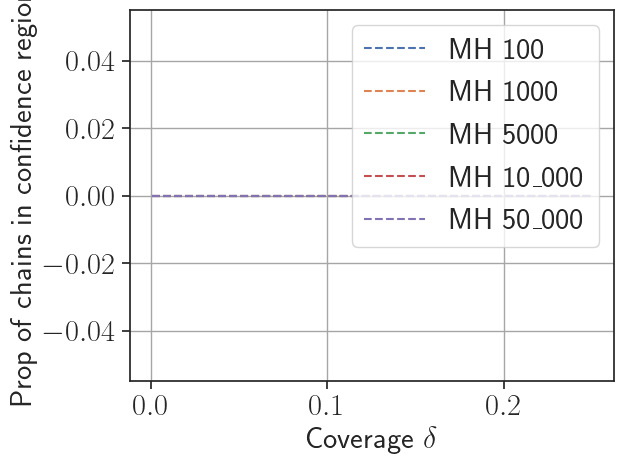

In [ ]:
fig, ax = plt.subplots()
#ax.plot(np.array(l_delta), l_gibbs, label = "Gibbs", ls = "--")
ax.plot(np.array(l_delta), l_mcmc_100, label = "MH 100", ls = "--")
ax.plot(np.array(l_delta), l_mcmc_1000, label = "MH 1000", ls = "--")
ax.plot(np.array(l_delta), l_mcmc_5000, label = "MH 5000", ls = "--")
ax.plot(np.array(l_delta), l_mcmc_10_000, label = "MH 10_000", ls = "--")
ax.plot(np.array(l_delta), l_mcmc_50_000, label = "MH 50_000", ls = "--")
plt.xlabel("$\delta$")
plt.ylabel("Prop of chains in confidence region")
plt.grid(True, which="both", ls="-", color='0.65')
ax.legend()
#ax.set_xscale('log')
plt.tight_layout()
plt.show()

# Bicluster bayesian logistic regression in 2D

In [ ]:
from sklearn.datasets import make_biclusters
import jax
!pip install blackjax
import blackjax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 13.2 MB/s eta 0:00:00


In [ ]:
#data
num_points = 50
X, rows, cols = make_biclusters(
    (num_points, 2), 2, noise=0.6, random_state=314, minval=-3, maxval=3
)
y = rows[0] * 1.0  # y[i] = whether point i belongs to cluster 1

In [ ]:
Phi = jnp.c_[jnp.ones(num_points)[:, None], X]
N, M = Phi.shape


def sigmoid(z):
    return jnp.exp(z) / (1 + jnp.exp(z))


def log_sigmoid(z):
    return z - jnp.log(1 + jnp.exp(z))


def logdensity_fn(w, alpha=1.0):
    """The log-probability density function of the posterior distribution of the model."""
    log_an = log_sigmoid(Phi @ w)
    an = Phi @ w
    log_likelihood_term = y * log_an + (1 - y) * jnp.log(1 - sigmoid(an))
    prior_term = jnp.where(w @ w > 25 / alpha, jnp.inf, alpha * w @ w / 2)

    return -prior_term + log_likelihood_term.sum()

In [ ]:
rng_key, init_key = random.split(key, 2)

w0 = jax.random.multivariate_normal(init_key, 0.1 + jnp.zeros(M), jnp.eye(M))
rmh = blackjax.rmh(logdensity_fn, blackjax.mcmc.random_walk.normal(jnp.ones(M) * 0.05))
initial_state = rmh.init(w0)

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [ ]:
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, rmh.step, initial_state, 100_000)#long mh

In [ ]:
burnin = 300
chains = states.position[burnin:, :]
nsamp, _ = chains.shape

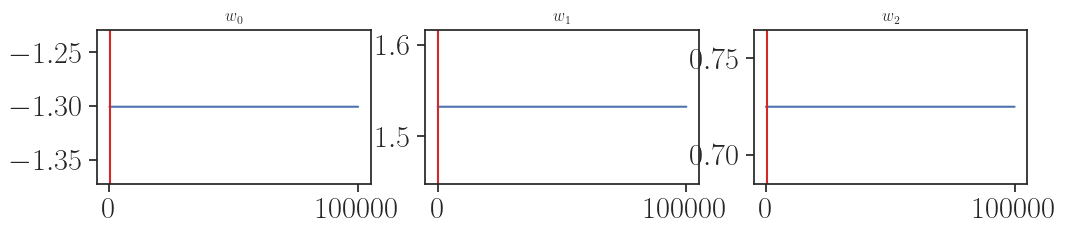

In [ ]:
burnin = 300

fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()

In [ ]:
#predictive distribution
# Create a meshgrid
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1
step = 0.1
Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = Xspace.shape

# Compute the average probability to belong to the first cluster at each point on the meshgrid
Phispace = jnp.concatenate([jnp.ones((1, nx, ny)), Xspace])
Z_mcmc = sigmoid(jnp.einsum("mij,sm->sij", Phispace, chains))
Z_mcmc = Z_mcmc.mean(axis=0)

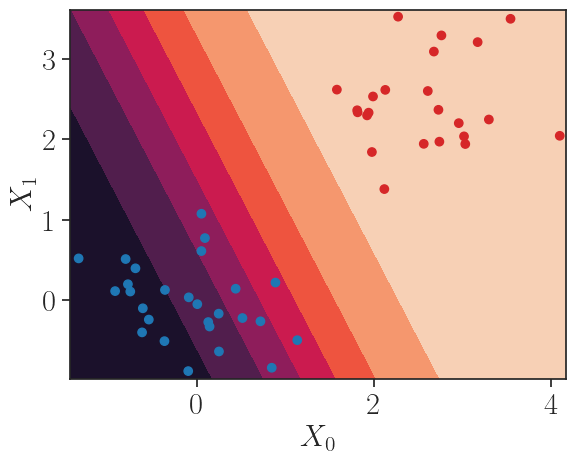

In [ ]:
plt.contourf(*Xspace, Z_mcmc)
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X.T, c=colors)
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$");

In [ ]:
#sample test data
num_points = 10
X_test, rows, cols = make_biclusters(
    (num_points, 2), 2, noise=0.6, random_state=246, minval=-3, maxval=3
)
y_test = rows[0] * 1.0  # y[i] = whether point i belongs to cluster 1

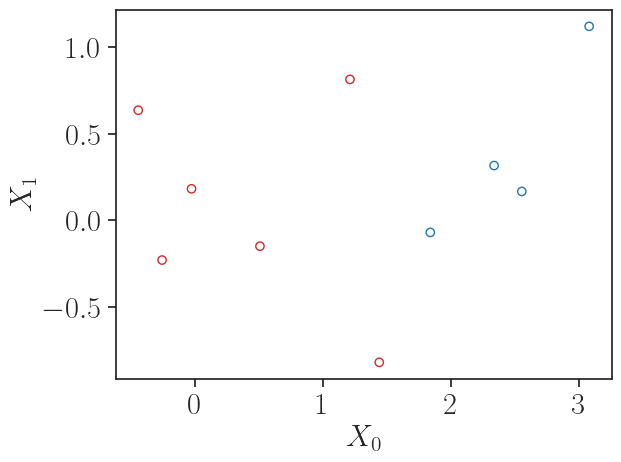

In [ ]:
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X_test.T, edgecolors=colors, c="none")
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$");

In [ ]:
#short mhs
#mh samples
key, _ = random.split(key, 2)
n_chains = 50
d = 3
key, _ = random.split(key, 2)
log_prob_target = lambda x : jnp.array(logdensity_fn(x[0, :]))
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = log_prob_target,
                                n_iter = 10_000,
                                step_size = 0.1))
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= jnp.eye(d))
initial_positions = mvn.sample(key, (n_chains, ))
sample_mh_full, acceptance = jit(sample_mh_jit)(random.split(key, n_chains), initial_positions)
print(acceptance)
sample_mh_100 = sample_mh_full[:, 500:600, :]
sample_mh_1000 = sample_mh_full[:, 500:1500, :]
sample_mh_5000 = sample_mh_full[:, 500:5500, :]
sample_mh_10_000 = sample_mh_full[:, 500:10_500, :]

[[0.4771]
 [0.4696]
 [0.476 ]
 [0.4795]
 [0.4736]
 [0.4787]
 [0.4746]
 [0.4822]
 [0.4771]
 [0.473 ]
 [0.4706]
 [0.481 ]
 [0.4775]
 [0.4756]
 [0.4901]
 [0.479 ]
 [0.472 ]
 [0.4732]
 [0.4782]
 [0.4811]
 [0.4786]
 [0.4812]
 [0.4937]
 [0.4833]
 [0.4872]
 [0.47  ]
 [0.4839]
 [0.4793]
 [0.4789]
 [0.4738]
 [0.4819]
 [0.4749]
 [0.4777]
 [0.4791]
 [0.4715]
 [0.4749]
 [0.4844]
 [0.4795]
 [0.479 ]
 [0.4832]
 [0.4785]
 [0.4733]
 [0.4777]
 [0.4848]
 [0.4778]
 [0.4744]
 [0.4748]
 [0.4851]
 [0.4692]
 [0.474 ]]


In [ ]:
key, _ = random.split(key, 2)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= jnp.eye(d))
initial_positions = mvn.sample(key, (1, ))
sample_pot_mh, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
key, _ = random.split(key, 2)
indexes = random.randint(key, shape = (1_000, ), minval = jnp.array([1_000]), maxval = jnp.array([10_000]))
sample_mh_pot = sample_pot_mh[0, indexes, :].T

In [ ]:
def V_ext(x):

    #R_2 = 4*9*(5* sigma)**2
    #R_2 = 25*81
    outlier = (log_prob_target(x.reshape((1, 3))) == -jnp.inf)
    #outlier = norm_2_safe_for_grad(x) >= R_2
    #res = jnp.where(outlier, norm_2_safe_for_grad(x) - R_2, 0.)
    res = jnp.where(outlier, jnp.inf, 0.)
    return res

def V(x) :
    d, N_mh = sample_mh_pot.shape
    #attention dans le papier simods j'ai pris le même échantillon mcmc pour tous les x, c'est ok car on a les garanties en W_1 mais est ce qu'on a pas intérêt à indep ?
    k_inter = lambda j : K(x, sample_mh_pot[:, j])
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / N_mh
    v = V_ext(x) - v_inter
    #jax.debug.print("{v}", v = V_ext(x))

    return v

In [ ]:
#gibbs chains
n_chains = 1
N = 1_00
d = 3
#all_chains = jnp.zeros(shape = (n_chains, N, d))
#dic_chain_gibbs_100_2d = {"chains": all_chains}
beta_N = 2*N**2
n_iter = 50_000
step_size = 0.1 * (beta_N)**(-1)
target_mala = gibbs(d = d, N = N, K = K, V = V, beta_N = beta_N)
mvn_d = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= jnp.eye(d))
mala_jitted = jit(vmap(partial(mala,
                               log_prob_target = target_mala.log_prob,
                               n_iter = n_iter,
                               step_size =  step_size)))



In [ ]:
#dic_chain_gibbs_100["n_iter"] = n_iter
#dic_chain_gibbs_100["step_size"] = step_size
#start sample
#mala chains
for i in range(n_chains):
    key, _ = random.split(key, 2)
    initial_positions = mvn.sample(key, (1, ))
    sample_mh_init, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
    key, _ = random.split(key, 2)
    indexes = random.randint(key, shape = (N, ), minval = jnp.array([1_000]), maxval = jnp.array([10_000]))
    start_sample = sample_mh_init[:, indexes, :].reshape(1, d*N)
    sample_mala, acceptance = mala_jitted(random.split(key, 1), start_sample)
    sample_mala_reshaped = sample_mala.reshape(N, d)
    print(acceptance)
    #all_acceptance = all_acceptance.at[i].set(acceptance[0])
    #all_chains = all_chains.at[i, :, :].set(sample_mala.reshape((N, d)))
    #dic_chain_gibbs_100["acceptance"] = all_acceptance
    #dic_chain_gibbs_100_2d["chains"] = all_chains
    #pickle.dump(dic_chain_gibbs_100_2d, open("drive/MyDrive/results_gretsi/mala_chains/chain_gibbs_100_2d.p", "wb"))

[0.72374]


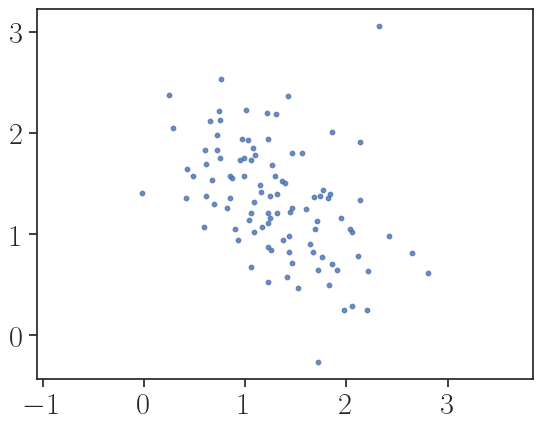

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala.reshape((N, d))[:, 1:3].T, alpha = 0.8, s = 10)
axes.axis('equal')
fig.savefig("gibbs_2_50_000.pdf")

TypeError: cannot reshape array of shape (100, 10000, 3) (size 3000000) into shape (100, 3) (size 300)

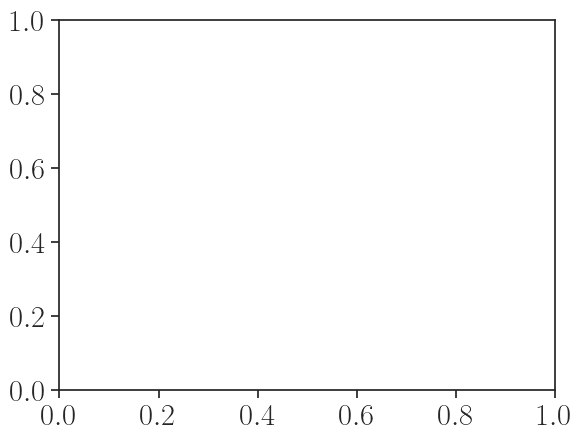

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mh_init[:, indexes, :].reshape((100, d))[:, 1:3].T, alpha = 0.8, s = 10)
#axes = plt.gca()
axes.axis('equal')
fig.savefig("mh_100.pdf")


In [ ]:
X_test.shape

(10, 2)

In [ ]:
sample_mh_full[0, 500:, :].shape

(9500, 3)

In [ ]:
jnp.concatenate([jnp.ones((1,)), X_test[0, :]])

Array([ 1.        , -0.4417695 ,  0.63566548], dtype=float64)

In [ ]:
(sample_mh_full[0, 500:, :] @ jnp.concatenate([jnp.ones((1,)), X_test[0, :]])).shape

(9500,)

In [ ]:
log_sigmoid(sample_mh_full[0, 500:, :] @ jnp.concatenate([jnp.ones((1,)), X_test[0, :]])).mean()

Array(-2.14132236, dtype=float64)

In [ ]:
def log_probs_sample(x):
    return jnp.array([log_sigmoid(x @ jnp.concatenate([jnp.ones((1,)), X_test[i, :]])).mean() for i in range(10)])

In [ ]:
#compute log probs on test set for bayes, and on average short mcmcs and gibbs
#log posterior probabilities for long MH
#log_post_bayes = np.array([log_posterior(sample_bayes_wo_burn[0, :, :], x = X_test[i, :], cat = cat) for cat in cats.keys()])
#log_probs_sample(sample_mh_full[0, 500:, :])
log_post_bayes = log_probs_sample(sample_mh_full[0, 500:, :])

In [ ]:
#idem for short MH
#mcmc 100
log_posts_mcmc_100 = jnp.array([log_probs_sample(sample_mh_100[j, :, :]) for j in range(n_chains)])

#mcmc 1000
log_posts_mcmc_1000 = jnp.array([log_probs_sample(sample_mh_1000[j, :, :]) for j in range(n_chains)])

#mcmc 5000
log_posts_mcmc_5000 = jnp.array([log_probs_sample(sample_mh_5000[j, :, :]) for j in range(n_chains)])

#mcmc 10_000
log_posts_mcmc_10_000 = jnp.array([log_probs_sample(sample_mh_10_000[j, :, :]) for j in range(n_chains)])

In [ ]:
#idem for Gibbs
gibbs_chain_100_2d = dic_chain_gibbs_100_2d["chains"]
log_posts_gibbs = jnp.array([log_probs_sample(gibbs_chain_100_2d[j, :, :]) for j in range(n_chains)])

In [ ]:
def props_in_ci(log_posts, delta):
    n_chains, n_cats = log_posts.shape
    prop_ci = 0.
    #l_prob_ci_up = np.zeros(shape = (n_cats))
    l_prob_ci_up = np.array([np.inf for i in range(n_cats)])
    l_prob_ci_down = np.array([-np.inf for i in range(n_cats)])
    for i in range(n_cats):
        #if log_post_bayes[i] < np.log(1 - delta):
        l_prob_ci_up[i] = scipy.special.logsumexp(a = jnp.array([log_post_bayes[i], jnp.log(delta)]))
        #if log_post_bayes[i] > np.log(delta):
        l_prob_ci_down[i] = scipy.special.logsumexp(a = jnp.array([log_post_bayes[i], jnp.log(delta)]), b = jnp.array([1., -1.]))

    for j in range(n_chains):
        flag = True
        for i in range(n_cats):
            l_prob = log_posts[j, i]
            if l_prob > l_prob_ci_up[i] or l_prob < l_prob_ci_down[i]:
                flag = False
        if flag:
            prop_ci+=1.
    return prop_ci / n_chains


In [ ]:
log_post_bayes

Array([-2.14132236, -0.39197115, -1.99414992, -2.19800037, -0.81009127,
       -1.82432411, -2.98686835, -0.08056086, -0.38396038, -0.55651436],      dtype=float64)

In [ ]:
log_posts_gibbs[0, :]

Array([-2.17239617, -0.40987498, -2.01327983, -2.22334968, -0.82922022,
       -1.84200353, -3.01568083, -0.08707522, -0.39982158, -0.56763345],      dtype=float64)

In [ ]:
log_posts_mcmc_100[0, :]

Array([-2.248729  , -0.33111198, -1.90125192, -2.20595414, -0.68823865,
       -1.59763043, -2.99472153, -0.06466684, -0.32132629, -0.49396801],      dtype=float64)

In [ ]:
log_post_bayes.shape

(50, 10)

In [ ]:
l_delta = [k*1e-3 for k in range(1, 501)]
l_gibbs = np.array([props_in_ci(log_posts_gibbs, delta = delta) for delta in l_delta])
l_mcmc_100 = np.array([props_in_ci(log_posts_mcmc_100, delta = delta) for delta in l_delta])
l_mcmc_1000 = np.array([props_in_ci(log_posts_mcmc_1000, delta = delta) for delta in l_delta])
l_mcmc_5000 = np.array([props_in_ci(log_posts_mcmc_5000, delta = delta) for delta in l_delta])
l_mcmc_10_000 = np.array([props_in_ci(log_posts_mcmc_10_000, delta = delta) for delta in l_delta])

In [ ]:
dic_l = {"l_gibbs" : l_gibbs, "l_mcmc_100": l_mcmc_100, "l_mcmc_1000" : l_mcmc_1000, "l_mcmc_5000" : l_mcmc_5000, "l_mcmc_10_000": l_mcmc_10_000}
pickle.dump(dic_l, open("drive/MyDrive/results_gretsi/dic_l.p", "wb"))

In [ ]:
l_gibbs

array([0.  , 0.  , 0.02, 0.04, 0.18, 0.22, 0.28, 0.4 , 0.42, 0.56, 0.58,
       0.7 , 0.74, 0.76, 0.8 , 0.8 , 0.84, 0.86, 0.9 , 0.9 , 0.9 , 0.92,
       0.94, 0.94, 0.98, 0.98, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

In [ ]:
l_mcmc_100

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02,
       0.02, 0.04, 0.06, 0.06, 0.08, 0.1 , 0.1 , 0.1 , 0.1 , 0.12, 0.12,
       0.12, 0.12, 0.12, 0.16, 0.18, 0.2 , 0.22, 0.22, 0.22, 0.22, 0.22,
       0.26, 0.26, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.3 , 0.32,
       0.34, 0.34, 0.38, 0.38, 0.38, 0.4 , 0.44, 0.44, 0.44, 0.44, 0.46,
       0.46, 0.48, 0.48, 0.48, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52,
       0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.56, 0.56, 0.56, 0.56,
       0.56, 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 ,
       0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.62,
       0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74,
       0.74, 0.76, 0.76, 0.76, 0.76, 0.76, 0.78, 0.78, 0.78, 0.78, 0.78,
       0.78, 0.78, 0.78, 0.8 , 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82,
       0.82, 0.82, 0.82, 0.84, 0.84, 0.86, 0.86, 0.

In [ ]:
l_mcmc_1000

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.02, 0.08, 0.08,
       0.08, 0.1 , 0.12, 0.16, 0.16, 0.2 , 0.22, 0.28, 0.28, 0.32, 0.36,
       0.42, 0.46, 0.48, 0.54, 0.56, 0.56, 0.58, 0.58, 0.6 , 0.62, 0.64,
       0.68, 0.7 , 0.72, 0.72, 0.72, 0.74, 0.76, 0.76, 0.76, 0.78, 0.8 ,
       0.82, 0.82, 0.84, 0.86, 0.86, 0.86, 0.88, 0.9 , 0.9 , 0.9 , 0.92,
       0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92,
       0.92, 0.94, 0.94, 0.94, 0.94, 0.94, 0.96, 0.96, 0.96, 0.96, 0.96,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98,
       0.98, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

In [ ]:
l_mcmc_5000

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.1 , 0.1 , 0.12,
       0.18, 0.2 , 0.3 , 0.34, 0.38, 0.44, 0.44, 0.52, 0.52, 0.56, 0.6 ,
       0.62, 0.62, 0.66, 0.66, 0.72, 0.74, 0.78, 0.8 , 0.8 , 0.84, 0.86,
       0.92, 0.96, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

In [ ]:
l_mcmc_10_000

array([0.02, 0.02, 0.02, 0.02, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.2 , 0.22,
       0.28, 0.3 , 0.38, 0.42, 0.44, 0.46, 0.5 , 0.58, 0.58, 0.6 , 0.66,
       0.72, 0.74, 0.76, 0.76, 0.78, 0.78, 0.82, 0.82, 0.88, 0.9 , 0.9 ,
       0.92, 0.94, 0.96, 0.96, 0.96, 0.96, 0.96, 0.98, 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

In [ ]:
dic_l = pickle.load(open("drive/MyDrive/results_gretsi/dic_l.p", "rb"))

In [ ]:
l_gibbs = dic_l["l_gibbs"]
l_mcmc_100 = dic_l["l_mcmc_100"]
l_mcmc_1000 = dic_l["l_mcmc_1000"]
l_mcmc_5000 = dic_l["l_mcmc_5000"]
l_mcmc_10_000 = dic_l["l_mcmc_10_000"]


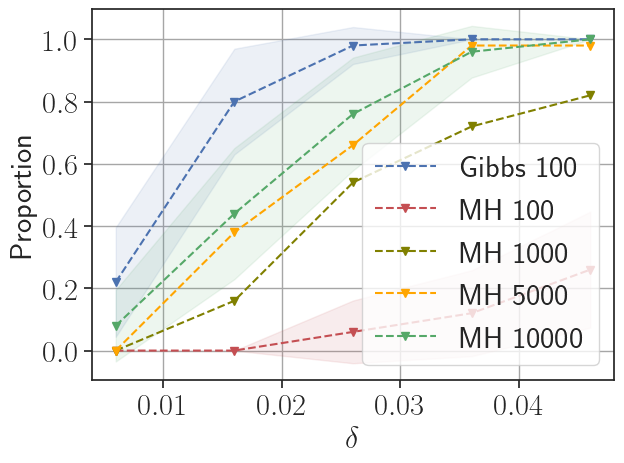

In [ ]:
fig, ax = plt.subplots()
l_delta = [k*1e-3 for k in range(1, 501)]
indexes = [5, 15, 25, 35, 45]

ax.plot(np.array(l_delta)[indexes], l_gibbs[indexes], label = "Gibbs 100", ls = "--", marker = "v", markersize = 6, color = 'b')
ax.fill_between(np.array(l_delta)[indexes], (l_gibbs[indexes]-l_ci_gibbs), (l_gibbs[indexes]+l_ci_gibbs), color='b', alpha=.1)

ax.plot(np.array(l_delta)[indexes], l_mcmc_100[indexes], label = "MH 100", ls = "--", marker = 'v', markersize = 6, color = 'r')
ax.fill_between(np.array(l_delta)[indexes], (l_mcmc_100[indexes] - l_ci_mcmc_100), (l_mcmc_100[indexes] +l_ci_mcmc_100), color='r', alpha=.1)

ax.plot(np.array(l_delta)[indexes], l_mcmc_1000[indexes], label = "MH 1000", ls = "--", marker = 'v', markersize = 6, color = 'olive')
#ax.fill_between(np.array(l_delta)[indexes], (l_mcmc_1000[indexes] - l_ci_mcmc_1000[:, 0]), (l_mcmc_1000[indexes]+ l_ci_mcmc_1000[:, 1]), color='b', alpha=.1)

ax.plot(np.array(l_delta)[indexes], l_mcmc_5000[indexes], label = "MH 5000", ls = "--", marker = 'v', markersize = 6, color = 'orange')
#ax.fill_between(np.array(l_delta)[indexes], (l_mcmc_5000[indexes]-l_ci_mcmc_5000[:, 0]), (l_mcmc_5000[indexes]+l_ci_mcmc_5000[:, 1]), color='b', alpha=.1)

ax.plot(np.array(l_delta)[indexes], l_mcmc_10_000[indexes], label = "MH 10000", ls = "--", marker = 'v', markersize = 6, color = 'g')
ax.fill_between(np.array(l_delta)[indexes], (l_mcmc_10_000[indexes]-l_ci_mcmc_10_000), (l_mcmc_10_000[indexes]+l_ci_mcmc_10_000), color='g', alpha=.1)
plt.xlabel("$\delta$")
plt.ylabel("Proportion")
plt.grid(True, which="both", ls="-", color='0.65')
ax.legend(loc = "lower right")
#ax.set_xscale('log')
plt.tight_layout()
plt.show()
fig.savefig("coverage_gretsi.pdf")

In [ ]:
indexes = [5, 15, 25, 35, 45]
def f(p_sample, n = 50):
    sigma2 = p_sample*(1-p_sample)**2 + (1-p_sample)*(0-p_sample)**2
    return 3*np.sqrt(sigma2/n)

l_ci_gibbs = np.array([f(l_gibbs[indexes[i]]) for i in range(5)])
l_ci_mcmc_100 = np.array([f(l_mcmc_100[indexes[i]]) for i in range(5)])
l_ci_mcmc_1000 = np.array([f(l_mcmc_1000[indexes[i]]) for i in range(5)])
l_ci_mcmc_5000 = np.array([f(l_mcmc_5000[indexes[i]]) for i in range(5)])
l_ci_mcmc_10_000 = np.array([f(l_mcmc_10_000[indexes[i]]) for i in range(5)])

In [ ]:
!pip install statsmodels
import statsmodels.stats.proportion

In [ ]:
l_ci_gibbs = np.array([statsmodels.stats.proportion.proportion_confint(count = l_gibbs[indexes[i]], nobs = 50, alpha=0.05/5, method = "beta") for i in range(5)])
l_ci_mcmc_100 = np.array([statsmodels.stats.proportion.proportion_confint(count = l_mcmc_100[indexes[i]], nobs = 50, alpha=0.05/5, method = "beta") for i in range(5)])
l_ci_mcmc_1000 = np.array([statsmodels.stats.proportion.proportion_confint(count = l_mcmc_1000[indexes[i]], nobs = 50, alpha=0.05/5, method = "beta") for i in range(5)])
l_ci_mcmc_5000 = np.array([statsmodels.stats.proportion.proportion_confint(count = l_mcmc_5000[indexes[i]], nobs = 50, alpha=0.05/5, method = "beta") for i in range(5)])
l_ci_mcmc_10_000 = np.array([statsmodels.stats.proportion.proportion_confint(count = l_mcmc_10_000[indexes[i]], nobs = 50, alpha=0.05/5, method = "beta") for i in range(5)])



In [ ]:
indexes = [5, 15, 25, 35, 45]
statsmodels.stats.proportion.proportion_confint(count = l_gibbs[indexes[2]], nobs = 50, alpha = 0.05/5, method = "beta")

(8.91706042653101e-05, 0.1386994242640142)

In [ ]:
statsmodels.stats.proportion.proportion_confint(count = l_gibbs[indexes[2]], nobs = 50, alpha = 0.05/5, method = "bin")

ValueError: count must have an integral dtype. Found data with dtype float64

In [ ]:
l_ci_gibbs

array([[4.56007922e-13, 1.09927320e-01],
       [2.42980499e-05, 1.32257573e-01],
       [8.91706043e-05, 1.38699424e-01],
       [1.00245812e-04, 1.39404125e-01],
       [1.00245812e-04, 1.39404125e-01]])

In [ ]:
l_ci_mcmc_10_000

array([[2.04648047e-31, 1.04035346e-01],
       [8.89816919e-08, 1.18735458e-01],
       [1.68160854e-05, 1.30800004e-01],
       [7.89572565e-05, 1.37992608e-01],
       [1.00245812e-04, 1.39404125e-01]])

In [ ]:
statsmodels.stats.proportion.proportion_confint(count = l_mcmc_10_000[indexes[2]], nobs = 50, alpha=0.05/5, method = "beta")

(1.6816085363138416e-05, 0.13080000363761002)